In [1]:
from gramex.cache import open as _open

In [13]:
from base64 import decodebytes
from skimage.io import imread
from io import BytesIO
from skimage.color import rgba2rgb
from skimage.transform import resize

In [16]:
import numpy as np

In [46]:
from gramex.data import filter as gfilter
df = gfilter('sqlite:///data/charts.db', table='charts')

In [47]:
to_keep = df['validated_label'].value_counts()[df['validated_label'].value_counts() > 1].index
df = df[df['validated_label'].isin(to_keep)]
df.head()

,label,validated_label,image,chart_id,is_validated
0,bar,circlepacking,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",4,1
1,populationpyramid,populationpyramid,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",9,1
2,waterfall,waterfall,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",10,1
3,network,network,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",11,1
4,treemap,treemap,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",12,1


In [9]:
from h5py import File

In [10]:
from tqdm import tqdm

In [48]:
X = np.zeros((df.shape[0], 224, 224, 3))

In [49]:
for i, (_, row) in tqdm(enumerate(df.iterrows()), total=df.shape[0]):
    imgdata = row['image'].split(',')[-1]
    bytedata = decodebytes(imgdata.encode())
    image = imread(BytesIO(bytedata))
    image = rgba2rgb(image)
    image = resize(image, (224, 224), preserve_range=True)
    X[i] = image

100%|██████████| 502/502 [00:22<00:00, 21.91it/s]


In [50]:
ix = np.random.randint(0, df.shape[0], size=(16,))

In [51]:
ix

array([417, 412, 377, 167, 484, 445, 468, 386, 137, 209, 195, 391, 207,
       371, 306, 292])

In [52]:
from matplotlib import pyplot as plt

In [53]:
%matplotlib inline

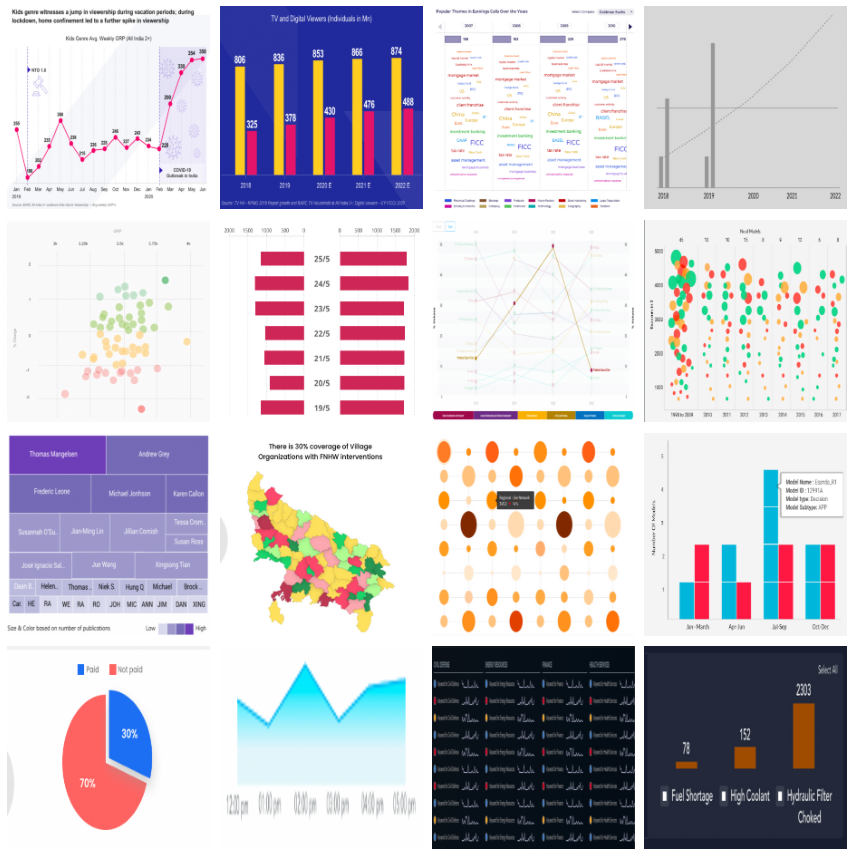

In [54]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

for i in range(4):
    for j in range(4):
        c = i * 4 + j
        ax[i, j].imshow(X[ix[c]])
        ax[i, j].axis('off')
plt.tight_layout()

In [55]:
df['validated_label'].value_counts()

map                        63
barchart                   37
donut                      25
multiline                  23
scatterplot                22
stacked-column             21
groupbar                   15
network                    15
ordered-bar                15
sankey                     15
dotmatrix                  15
sunburst                   15
treemap                    15
bubblechartlegend          14
area-chart                 14
linechart                  13
waffle                     10
wordcloud                   9
circlepacking               9
heatmap                     9
populationpyramid           8
column                      7
dot-strip-plot              7
dendrogram                  7
pie                         7
quadrant                    6
parallelcoordinates         6
proportional-area-chart     6
waterfall                   6
table                       5
radialbar                   5
pyramid                     5
radarchart                  4
funnel    

In [56]:
from sklearn.preprocessing import LabelEncoder

In [57]:
lenc = LabelEncoder()

In [58]:
y = lenc.fit_transform(df['validated_label'])

In [37]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import *
from tensorflow.keras import Model
from tensorflow.keras.losses import CategoricalCrossentropy

In [59]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [65]:
model.trainable = False
ip_layer = layers.Input(shape=(224, 224, 3))
x = model(ip_layer, training=False)
x = layers.Dense(52)(x)
outer = Model(ip_layer, x)

outer.compile(optimizer=Adam(lr=0.05),
              loss=CategoricalCrossentropy(from_logits=True), metrics=['categorical_accuracy'])

In [61]:
y = to_categorical(y)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, stratify=np.argmax(y, axis=1))

In [62]:
xtrain.shape

(336, 224, 224, 3)

In [63]:
xtest.shape

(166, 224, 224, 3)

In [67]:
history = outer.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=16, epochs=1000)

Epoch 1/1000
21/21 [==============================] - 2s 78ms/step - loss: 2.0741 - categorical_accuracy: 0.4524 - val_loss: 2.7337 - val_categorical_accuracy: 0.3253
Epoch 2/1000
21/21 [==============================] - 2s 78ms/step - loss: 2.0639 - categorical_accuracy: 0.4464 - val_loss: 2.7289 - val_categorical_accuracy: 0.3253
Epoch 3/1000
21/21 [==============================] - 2s 77ms/step - loss: 2.0551 - categorical_accuracy: 0.4702 - val_loss: 2.7286 - val_categorical_accuracy: 0.3133
Epoch 4/1000
21/21 [==============================] - 2s 80ms/step - loss: 2.0506 - categorical_accuracy: 0.4792 - val_loss: 2.7267 - val_categorical_accuracy: 0.3133
Epoch 5/1000
21/21 [==============================] - 2s 76ms/step - loss: 2.0487 - categorical_accuracy: 0.4702 - val_loss: 2.7271 - val_categorical_accuracy: 0.3253
Epoch 6/1000
21/21 [==============================] - 2s 78ms/step - loss: 2.0456 - categorical_accuracy: 0.4494 - val_loss: 2.7216 - val_categorical_accuracy: 0.307

KeyboardInterrupt: 

In [68]:
history

In [69]:
def plot_model(history):
    fig, ax = plt.subplots()
    for k, v in history.history.items():
        ax.plot(v, label=k)
    plt.legend()

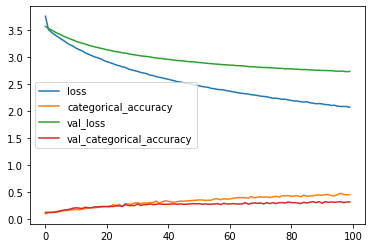

In [70]:
plot_model(history)